In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
#from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 
#from ClassificationModels.ResNet import Classifier_RESNET
#from ClassificationModels.CNN import Classifier_CNN
from tslearn.datasets import UCR_UEA_datasets

# Parameters

In [2]:
dataset='NATOPS'

# Load Data

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [4]:
print(train_x.shape)
print(test_x.shape)

(180, 51, 24)
(180, 51, 24)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder_tf.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

In [6]:
train_x.shape

(180, 51, 24)

In [7]:
train_y.shape

(180, 6)

# Load Model

In [8]:

import tensorflow as tf 

#model = Classifier_CNN(f'./ClassificationModels/models/{dataset}', (train_x.shape[1], train_x.shape[2]), train_y.shape[-1], True)
#y_true = np.argmax(test_y, axis=1)
#model.fit(train_x,train_y,test_x,test_y)


model = tf.keras.models.load_model(f'../ClassificationModels/models/{dataset}/cnn/NATOPSbest_model.hdf5')

# Explanation Algo

In [9]:
item=test_x[10].reshape(1,test_x.shape[1],test_x.shape[2])
shape=item.shape
y_target= model.predict(item)

In [10]:
print(y_target)

[[1.4650476e-07 1.8041396e-08 1.3309717e-04 1.5583634e-04 9.9330294e-01
  1.4406322e-05]]


In [11]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import AtesCF

exp_model= AtesCF(model,(train_x,train_y),mode='time', backend='TF')


In [12]:
exp = exp_model.explain(item,3, method= 'opt')

Target [3]


In [13]:
exp

(array([[[-0.60969 , -1.653633, -0.887898, ..., -0.611379, -1.65367 ,
          -0.886642],
         [ 0.523864, -1.874153, -0.666274, ...,  0.525813, -1.873512,
          -0.661249],
         [-0.69437 , -0.678901, -0.336247, ..., -0.694311, -0.675182,
          -0.337719],
         ...,
         [ 0.871105, -1.413926, -0.383612, ...,  0.933799, -1.427527,
          -0.132535],
         [-1.215168, -1.578678, -0.574377, ..., -1.122646, -1.589755,
          -0.611878],
         [ 0.763644, -1.632191, -0.496652, ...,  0.771005, -1.634684,
          -0.49646 ]]]),
 array([3]))

In [14]:
array, label=exp

In [15]:
print(label.shape)

(1,)


In [16]:
%matplotlib inline
plt.style.use("classic")
colors = [
            '#08F7FE',  # teal/cyan
            '#FE53BB',  # pink
            '#F5D300',  # yellow
            '#00ff41',  # matrix green
        ]
        
#Figure out number changed channels
##index= np.argwhere(np.any(item!=array,axis=1))
#index
item=item.reshape(item.shape[0],item.shape[2],item.shape[1])
res = ( item!= array).any(-1)
ind=np.where(res[0])

print(res)
print(ind[0][0])

[[ True False False False  True  True  True  True  True  True  True False
   True  True  True  True False  True  True  True False False False  True]]
0


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


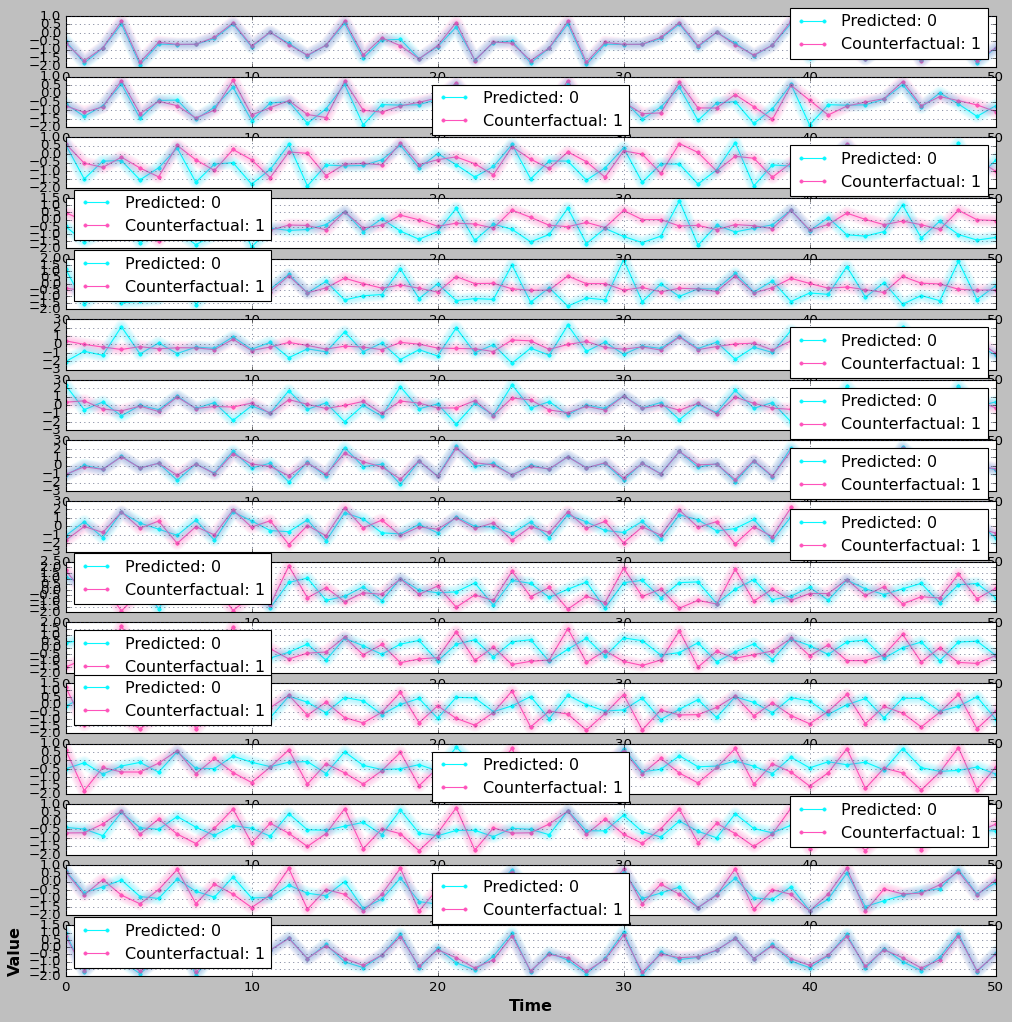

In [17]:

i=0
org_label=0
cf_label=1
exp=array
fig, ax = plt.subplots(len(ind[0]),1,figsize=(15,15))
print(ax)
for channel in ind[0]:
    #fig,ax=plt.subplot(len(ind[0]),1,i)
    
    df = pd.DataFrame({f'Predicted: {org_label}': list(item[0][channel].flatten()),
                   f'Counterfactual: {cf_label}': list(exp[0][channel].flatten())})
    
    df.plot(marker='.', color=colors, ax=ax[i])
        # Redraw the data with low alpha and slighty increased linewidth:
    n_shades = 10
    diff_linewidth = 1.05
    alpha_value = 0.3 / n_shades
    for n in range(1, n_shades+1):
        df.plot(marker='.',
        linewidth=2+(diff_linewidth*n),
        alpha=alpha_value,
        legend=False,
        ax=ax[i],
        color=colors)

    ax[i].grid(color='#2A3459')
    plt.xlabel('Time', fontweight = 'bold', fontsize='large')
    plt.ylabel('Value', fontweight = 'bold', fontsize='large')
    i=i+1
    #plt.savefig('../Images/Initial_Example_Neon.pdf')
plt.show()